In [1]:
'''
Available methods are the followings:
[1] rollrate_table
[2] plot_rollrate
[3] vintage_table
[4] plot_vintage
[5] avgdpd_table
[6] plot_avgdpd

Author: Danusorn Sitdhirasdr <danusorn.si@gmail.com>
versionadded:: 30-05-2022

'''
import time
from calendar import monthrange
import pandas as pd, numpy as np
from matplotlib.colors import (ListedColormap, 
                               LinearSegmentedColormap)
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.transforms as transforms
from matplotlib.ticker import(FixedLocator, 
                              FixedFormatter, 
                              StrMethodFormatter,
                              FuncFormatter)

__all__ = ["rollrate_table", "plot_rollrate", 
           "vintage_table" , "plot_vintage", 
           "avgdpd_table"  , "plot_avgdpd"]

In [2]:
def delq_table(delq, values) -> pd.DataFrame:
    
    '''
    ** Private Function **
    Delinquency table
    '''
    columns = list(delq)
    bins = np.array([ 0., 29, 59., 89., np.inf])
    states = ["(1) Clean"     , "(2) 0<dpd<30" , 
              "(3) 30<=dpd<60", "(4) 60<=dpd<90", 
              "(5) dpd>90"]
    delq = np.digitize(delq.values, bins, right=True)
    delq = np.select([delq==n for n in range(len(bins))], states, -1)
    delq = pd.DataFrame(delq, columns=columns)
    if values is None: delq["value"] = 1
    else: delq["value"] = values

    dummy = dict([(c,states) for c in columns])
    dummy.update({"value": np.zeros(len(states))})
    return delq.append(pd.DataFrame(dummy), ignore_index=True)

In [3]:
def rollrate_table(X, mobs, values=None, percent=False):
    
    '''
    Roll rate is the proportion of customers who will be 'better', 
    'worse' or 'remain same' with time in terms of delinquency.
    
    Parameters
    ----------
    X : pd.DataFrame of shape (n_samples, n_mobs)
        Input data.
    
    mobs : list of variable names [start_mob, end_mob]
        Variables within data to use as starting and ending periods
        e.g. ["M4", "M12"] starts at 4 Months on book and ends at 12
        Months on book.
    
    values : np.ndarray, default=None
         An array of shape (n_samples,) to aggregate. If None, it
         defaults to an array of shape (n_samples,) filled with ones.
         
    percent : bool, default=False
        If True, it displays in percentage, otherwise actual number.
        
    References
    ----------
    [1] https://www.listendata.com/2019/09/roll-rate-analysis.html#:
        ~:text=Roll%20rate%20analysis%20is%20used,for%2090%20days%20
        or%20more.
         
    Returns
    -------
    df : pd.DataFrame
    
    '''
    start, end = mobs
    df = pd.pivot_table(delq_table(X[mobs].copy(), values), 
                        values='value', index=start, 
                        columns=end, aggfunc=np.sum).fillna(0)
    if percent==False: return df
    else: return (df/df.values.sum(1,keepdims=True)).fillna(0)

In [4]:
def plot_rollrate(delq, mobs, values=None, ax=None, colors=None, 
                  num_format=None, labels=None, tight_layout=True):
    '''
    Plot Roll-Rate
    
    Parameters
    ----------
    delq : pd.DataFrame of shape (n_samples, n_mobs)
        Input data.
    
    mobs : list of variable names [start_mob, end_mob]
        Variables within data to use as starting and ending periods
        e.g. ["M4", "M12"] starts at 4 Months on book and ends at 12
        Months on book.
    
    values : np.ndarray, default=None
         An array of shape (n_samples,) to aggregate. If None, it
         defaults to an array of shape (n_samples,) filled with ones.
         
    ax : matplotlib Axes, default=None
        Axes object to draw the plot onto, otherwise uses the default 
        axis with figsize = (8.3, 5.8).
        
    colors : list of color-hex, default=None
        Number of color-hex must be greater than or equal to 3 i.e. 
        ["better", "remain", "worst"]. If None, it uses default 
        colors.
  
    num_format : string formatter, default=None
        String formatters (function) for all numbers except 
        percentage. If None, it defaults to "{:,.0f}".format.
    
    labels : list of str, default=None
        List of labels for x, and y axes i.e. [xlabel, ylabel]. If 
        None, it defaults to ["Current Month", "Previous Month"].
    
    tight_layout : bool, default=True
        If True, it adjusts the padding between and around subplots 
        i.e. plt.tight_layout().
         
    Returns
    -------
    ax : matplotlib Axes
        Returns the Axes object with the plot drawn onto it.
        
    '''
    # Default matplotlib figure, and axis.
    if ax is not None: fig = plt.gcf()
    else: fig, ax = plt.subplots(figsize=(8.3, 5.8))
    
    # Initialize parameters
    start, end = mobs
    if colors is None: colors = ["#1B9CFC", "#ffffff", "#FC427B"]
    if num_format is None: num_format = "{:,.0f}".format
    labels_ = ["Clean (0)", "1-29", "30-59", "60-89", "90+"]

    # Plot `matshow`
    a = np.array([np.arange(5)[::-1]-n for n in range(4,-1,-1)]).T
    cmap = LinearSegmentedColormap.from_list("customized", colors, N=9)
    cax = ax.matshow(a, cmap=cmap , alpha=0.9, interpolation='nearest')

    # Create colorbar
    notches = np.unique(a)
    ticks = np.linspace(min(notches)+0.5,
                        max(notches)-0.5, len(notches))
    cbar = fig.colorbar(cax, ax=ax, ticks=ticks, pad=0.12)
    cbar.ax.set_yticklabels(["{:d}".format(n) for n in notches])
    cbar.ax.set_ylabel("Delinquency Movement (Notch)", 
                       rotation=-90, va="bottom", fontsize=13)

    # Create annotation (N, %)
    coords = [(r,c) for r in range(5) for c in range(5)]
    args = (delq, mobs, values)
    delq_cnt = rollrate_table(*args, False).values.T.ravel()
    delq_pct = rollrate_table(*args, True ).values.T.ravel()
    for n in range(25):
        ax.annotate(num_format(delq_cnt[n]), coords[n], 
                    textcoords="offset points", xytext=(0,2), 
                    va="bottom", ha="center", fontsize=12)
        ax.annotate("({:.0%})".format(delq_pct[n]), coords[n], 
                    textcoords="offset points", xytext=(0,-2), 
                    va="top", ha="center",fontsize=12)

    # Grid lines
    for n in np.arange(0.5,4): 
        ax.axvline(n, lw=0.8, color="k")
        ax.axhline(n, lw=0.8, color="k")

    # Ticklabels on x-axis
    ax.set_xticks(range(5))
    tot_cnt = delq_cnt.reshape((5,5)).T.sum(0)
    ax.set_xticklabels([f"{s}" + "\n(" + num_format(v) +")" 
                        for s,v in zip(labels_, tot_cnt)], 
                       fontsize=13)
    
    # Ticklabels on y-axis
    ax.set_yticks(range(5))
    tot_cnt = delq_cnt.reshape((5,5)).T.sum(1)
    ax.set_yticklabels([f"{s}" + "\n(" + num_format(v) +")"
                        for s,v in zip(labels_,tot_cnt)], 
                       fontsize=13)

    # Labels 
    if labels is None: labels = ["Current Month", "Previous Month"]
    kwds = dict(fontsize=14, fontweight=600)
    ax.xaxis.set_label_position('top')
    ax.tick_params(which="both", bottom=False, left=False, top=False)
    ax.set_xlabel(labels[0], **kwds)
    ax.set_ylabel(labels[1], **kwds)
    
    # % of roll-forward and roll-backward
    trans = delq_pct.reshape(a.shape).T
    backward = np.where(np.sign(a)==-1, trans, 0).sum(1)
    forward  = np.where(np.sign(a)== 1, trans, 0).sum(1)
    for n in range(5):
        # Roll forward
        s = r"$\leftarrow$" + "{:.0%}".format(backward[n])
        ax.annotate(s, (4.5,n), textcoords="offset points", 
                    xytext=(2,2), va="bottom", ha="left", 
                    fontsize=12, color=colors[0])
        # Roll forward
        s = r"$\rightarrow$" + "{:.0%}".format(forward[n])
        ax.annotate(s, (4.5,n), textcoords="offset points", 
                    xytext=(2,-2), va="top", ha="left", 
                    fontsize=12, color=colors[-1])

    # Draw lines that separate unchanged group and the others.
    line = np.sort(np.r_[np.arange(-0.5,5),np.arange(-0.5,5)]) 
    ax.plot(line[:-3]+1, line[1:-2], lw=3, color="#2f3542")
    ax.plot(line[1:-2] , line[2:-1], lw=3, color="#2f3542")
    if tight_layout: plt.tight_layout()

    return ax

In [5]:
def vintage_table(X, groupby, dpd_cols, dpd_geq=30):
    '''Vintage analysis'''
    groupby, dpd_cols = list(groupby), list(dpd_cols)
    new_X = X[groupby + dpd_cols].copy()
    new_X[dpd_cols] = np.cumsum(new_X[dpd_cols].values>=dpd_geq,axis=1)>0
    new_X["N"] = 1
    aggfnc = {**{"N":"count"},**dict([(c,"mean") for c in dpd_cols])}
    return new_X.groupby(groupby).agg(aggfnc)

In [6]:
def groupby_table(X, groupby, cols, agg=np.nanmean, factor=1):
    '''Groupby'''
    groupby, dpd_cols = list(groupby), list(cols)
    new_X = X[groupby + cols].copy()
    new_X["N"] = 1
    aggfnc = {**{"N":"count"},**dict([(c,agg) for c in dpd_cols])}
    new_X  = new_X.groupby(groupby).agg(aggfnc)
    new_X[cols] = new_X[cols]*factor
    return new_X

In [7]:
def color_map(colors, N):
    '''Return `N` shades of colors from `colors`'''
    cmap = LinearSegmentedColormap.from_list("customized", colors, N=N)
    c_hex = '#%02x%02x%02x'
    c = cmap(np.linspace(0,1,N))
    c = (c*255).astype(int)[:,:3]
    return [c_hex % (c[i,0],c[i,1],c[i,2]) for i in range(N)]

In [8]:
def plot_vintage(X, groupby, dpd_cols, dpd_geq=30, start_mth=0, 
                 ax=None, num_format=None, colors=None, 
                 plot_kwds=None, tight_layout=True, loc=None, 
                 focus=None, n_tops=None):
    '''
    Vintage plots.
    
    Parameters
    ----------
    X : pd.DataFrame of shape (n_samples, n_mobs)
        Input data.
    
    groupby : list of labels
        Used to determine the groups (columns) for the groupby.
    
    dpd_cols : list of labels
        List of delinquency or Day-Past-Due (DPD) columns.
    
    dpd_geq : int, default=30
        Any delinquency that is greater or equal to `dpd_geq` will
        be marked as ever-delinquent.
    
    start_mth : int, default=0
        The starting month(s) on book.
         
    ax : matplotlib Axes, default=None
        Axes object to draw the plot onto, otherwise uses the default 
        axis with figsize = max(6.3, n_mths*1.05).
        
    num_format : string formatter, default=None
        String formatters (function) for population count shown in 
        legend. If None, it defaults to "{:,.0f}".format.
        
    colors : list of color-hex, default=None
        Number of color-hex must be greater than or equal to 2. If 
        None, it uses default matplotlib colors.
  
    plot_kwds : keywords, default=None
        Keyword arguments to be passed to "ax.plot".
    
    tight_layout : bool, default=True
        If True, it adjusts the padding between and around subplots 
        i.e. plt.tight_layout().
    
    loc : str, default=None
        The location of the legend [1]. If None, legend will be 
        located on the right side of the plot.
        
    focus : str, default=None
        Column to focus from `dpd_cols`. If None, focusing is not
        implemented.
        
    n_tops : int, greater than 1, default=10
        Maximum number of top `n` groups to be displayed in colors,
        while the rest will be dimmed. If None, it displays all groups. 
        This is only relevant when `focus` is not None.
       
    References
    ----------
    [1] https://matplotlib.org/3.5.0/api/_as_gen/matplotlib.axes.Axes.
        legend.html
         
    Returns
    -------
    ax : matplotlib Axes
        Returns the Axes object with the plot drawn onto it.
    
    '''
    vintage = vintage_table(X, groupby, dpd_cols, dpd_geq).copy()
    n_lines, n_mths = len(vintage), len(dpd_cols)
    x = np.arange(len(dpd_cols))

    # Default parameters
    args = (plot_kwds, num_format, ax, 
            colors, n_lines, n_mths, loc)
    kwds, num_format, ax, colors = default_params(*args)
        
    # Find focus
    dim, indices = find_focus(vintage, focus, n_tops, n_lines)
    ax , samples = draw_lines(ax, vintage, x, dpd_cols, groupby, 
                              n_lines, dim, indices, num_format, 
                              kwds, colors)

    # Text (top left corner)
    ax = draw_text(ax, sum(samples), dpd_geq)
    
    # Set properties of x, and y axes.
    ax = set_axes(ax, x, start_mth, 
                  ylabel="Proportion", 
                  xlabel="Months on book", 
                  percent=True)

    # Draw focus line, and legend
    ax = draw_focus(ax, focus, dpd_cols)
    ax = draw_legend(ax, loc)
    if tight_layout: plt.tight_layout()
        
    return ax

In [9]:
def plot_avgdpd(X, groupby, dpd_cols, start_mth=0, ax=None, 
                num_format=None, colors=None, plot_kwds=None, 
                tight_layout=True, loc=None, focus=None, 
                n_tops=None):
    '''
    Averge delinquency or day-past-due plots.
    
    Parameters
    ----------
    X : pd.DataFrame of shape (n_samples, n_mobs)
        Input data.
    
    groupby : list of labels
        Used to determine the groups (columns) for the groupby.
    
    dpd_cols : list of labels
        List of delinquency or Day-Past-Due (DPD) columns.

    start_mth : int, default=0
        The starting month(s) on book.
         
    ax : matplotlib Axes, default=None
        Axes object to draw the plot onto, otherwise uses the default 
        axis with figsize = max(6.3, n_mths*1.05).
        
    num_format : string formatter, default=None
        String formatters (function) for population count shown in 
        legend. If None, it defaults to "{:,.0f}".format.
        
    colors : list of color-hex, default=None
        Number of color-hex must be greater than or equal to 2. If 
        None, it uses default matplotlib colors.
  
    plot_kwds : keywords, default=None
        Keyword arguments to be passed to "ax.plot".
    
    tight_layout : bool, default=True
        If True, it adjusts the padding between and around subplots 
        i.e. plt.tight_layout().
    
    loc : str, default=None
        The location of the legend [1]. If None, legend will be 
        located on the right side of the plot.
        
    focus : str, default=None
        Column to focus from `dpd_cols`. If None, focusing is not
        implemented.
        
    n_tops : int, greater than 1, default=10
        Maximum number of top `n` groups to be displayed in colors,
        while the rest will be dimmed. If None, it displays all groups. 
        This is only relevant when `focus` is not None.
       
    References
    ----------
    [1] https://matplotlib.org/3.5.0/api/_as_gen/matplotlib.axes.Axes.
        legend.html
         
    Returns
    -------
    ax : matplotlib Axes
        Returns the Axes object with the plot drawn onto it.
    
    '''
    # Get data table
    avgdpd = groupby_table(X, groupby, dpd_cols)
    n_lines, n_mths = len(avgdpd), len(dpd_cols)
    x = np.arange(len(dpd_cols))

    # Default parameters
    args = (plot_kwds, num_format, ax, 
            colors, n_lines, n_mths, loc)
    kwds, num_format, ax, colors = default_params(*args)   
        
    # Plot lines.
    dim, indices = find_focus(avgdpd, focus, n_tops, n_lines)
    ax , samples = draw_lines(ax, avgdpd, x, dpd_cols, groupby, 
                              n_lines, dim, indices, num_format, 
                              kwds, colors)

    # Text (top left corner)
    ax = draw_text(ax, sum(samples), None)
    
    # Set properties of x, and y axes.
    ax = set_axes(ax, x, start_mth,
                  ylabel="Average DPD (days)", 
                  xlabel="Months on book", 
                  percent=False)
    
    # Draw dpd-lines, focus-line, and legend
    ax = draw_dpd(ax)
    ax = draw_focus(ax, focus, dpd_cols)
    ax = draw_legend(ax, loc)
    if tight_layout: plt.tight_layout()
        
    return ax

In [10]:
def default_params(plot_kwds, num_format, ax, colors, 
                   n_lines, n_mths, loc):
    '''Private function: default parameters'''
    kwds = dict(linewidth=3, solid_capstyle='round', 
                solid_joinstyle="round", markersize=7,
                markeredgewidth=1)
    if plot_kwds is not None: kwds.update(plot_kwds)
    if num_format is None: num_format = "{:,.0f}".format  
    if ax is None: 
        width = max(6.3, n_mths*1.05) + (2 if loc is None else 0)
        ax = plt.subplots(figsize=(width, 4))[1]
    if colors is not None: colors = color_map(colors, n_lines)
    return kwds, num_format, ax, colors

In [11]:
def draw_lines(ax, data, x, dpd_cols, groupby, n_lines, 
               dim, indices, num_format, kwds, colors):
    '''Private function: plot lines'''
    data  = data.reset_index().copy()
    evers = data.loc[:, dpd_cols].values
    group = data.loc[:, groupby].astype(str).values
    samples = data["N"].values

    for n in range(n_lines):
        ever, N  = evers[n,:], num_format(samples[n])
        label = ", ".join(group[n,:]) + f" ({N})"
        if colors is not None: kwds.update({"color":colors[n]})
        if dim & (n not in indices):
            ax.plot(x, ever, label=label, 
                    **{**kwds, **{"color":"#dfe4ea", "zorder":-1}})
        else: ax.plot(x, ever, label=label, **kwds)
    return ax, samples

In [12]:
def draw_text(ax, n_samples, dpd_geq=None):
    '''Private function: draw text (top left corner)'''
    args = (ax.transAxes, ax.transAxes)
    trans= transforms.blended_transform_factory(*args)
    if dpd_geq is None: text = []
    else: text = [r"DPD $\geq$ " + "{:,d} day(s)".format(dpd_geq)]
    text += ["N = {:,d}".format(n_samples)]
    ax.text(0.01, 1, "\n".join(text), transform=trans, fontsize=13, 
            va="top", ha="left", color="k", 
            bbox=dict(pad=2, facecolor="w", edgecolor="none"))
    return ax

In [13]:
def draw_dpd(ax):
    '''Private function: draw dpd lines'''
    y_min, y_max = ax.get_ylim() 
    args = (ax.transAxes, ax.transData)
    trans = transforms.blended_transform_factory(*args)
    for d in [30, 60, 90, 120]:
        if d<=y_max:
            ax.axhline(d, lw=0.8, ls="--", color="#cccccc", zorder=-1)
            text = "{:,d} days".format(d)
            ax.text(0.01, d, text, transform=trans, fontsize=12, 
                    va="bottom", ha="left", color="#cccccc", zorder=-1)
    return ax

In [47]:
def set_axes(ax, x, start_mth, ylabel, xlabel="Months on book", 
             percent=True):
    '''Private function: set properties of x, and y axes'''
    y_min, y_max = ax.get_ylim() 
    ax.set_ylim(y_min, y_max/0.85)
    for s in ["right","top"]:ax.spines[s].set_visible(False) 
    ax.set_xticks(x + start_mth)
    # ax.set_xticklabels(x + start_mth)
    ax.set_xlabel(xlabel, fontsize=13, fontweight=600)
    ax.set_ylabel(ylabel, fontsize=13, fontweight=600)
    ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(5))
    ax.set_facecolor('white')
    ax.patch.set_alpha(0)
    ax.tick_params(axis='both', labelsize=12)
    if percent:
        t = mpl.ticker.PercentFormatter(xmax=1)
        ax.yaxis.set_major_formatter(t)
    return ax

In [15]:
def find_focus(data, focus, n_tops, n_lines):
    '''Private Function: find focus'''
    if focus is not None:
        if focus in dpd_cols:
            n_tops= max(min(n_tops, n_lines),1)
            indices = data.fillna(0).reset_index()\
            .sort_values(by=focus,ascending=False).copy()
            indices = np.array(indices.index)[:n_tops]
            return True, indices
        else: return False, []
    return False, []

In [16]:
def draw_focus(ax, focus, dpd_cols):
    '''Private function: draw focus line'''
    if focus is not None:
        index = np.isin(dpd_cols, [focus])
        if sum(index)>0:
            k = np.argmax(index)
            ax.axvline(k, lw=1, color="#cccccc", zorder=-1)
            args = (ax.transData, ax.transAxes)
            trans = transforms.blended_transform_factory(*args)
            ax.text(k, 1, focus, transform=trans, fontsize=13, 
                    va="bottom", ha="center", color="grey")
    return ax

In [17]:
def draw_legend(ax, loc):
    '''Private function: draw legend'''
    kwds = dict(fontsize=12, framealpha=0)
    if loc is None:
        legend = ax.legend(loc="upper left", **kwds) 
        legend.set_bbox_to_anchor([1,1], transform=ax.transAxes)
    else: ax.legend(loc=loc, **kwds)
    return ax

In [18]:
import pandas as pd, numpy as np, time
from calendar import monthrange

def create_mob(X, dt_fmt="%d-%m-%y %H:%M"):
    
    start_time = time.time()    
    # Required fields
    fields = ["ip_id", "pd_lvl2", "cust_type", "apl_grp_no", 
              "apl_grp_type","fico_scor", "lnd_pos_dt", 
              "fnl_apl_dcsn_dt", "dlq_dys", "otsnd_bal_amt", 
              "pnp_amt", "fnl_cr_lmt"]
    
    # Groupby fields
    groupby= ["ip_id", "pd_lvl2", "cust_type", "apl_grp_no", 
              "apl_grp_type", "fnl_apl_dcsn_dt"]
    
    X = X[fields].copy()

    # Convert fields to `np.datetime64`
    dt0, dt1, dt2 = "fnl_apl_dcsn_dt", "lnd_pos_dt", "month"
    X[dt0] = pd.to_datetime(X[dt0], format=dt_fmt).dt.date
    X[dt0] = X[dt0].apply(lambda x: end_of_mth(x))
    X[dt1] = pd.to_datetime(X[dt1], format=dt_fmt).dt.date
    
    # Months on book
    X[dt2] =  np.round(((X[dt1] - X[dt0])/np.timedelta64(1,'M')),0)
    X = X.sort_values(by=["ip_id","apl_grp_no","lnd_pos_dt"])\
    .reset_index(drop=True)
    
    # Create fields for each month
    start, end = np.percentile(X[dt2].values, q=[0,100])
    X["dlq_day"] = [a for a in zip(X[dt2], X["dlq_dys"])]
    X["os_bals"] = [a for a in zip(X[dt2], X["otsnd_bal_amt"])]
    X["pnpamts"] = [a for a in zip(X[dt2], X["pnp_amt"])]
    
    # Aggregate functions
    aggfunc = {"dlq_day": create_cols(start, end), 
               "os_bals": create_cols(start, end),
               "pnpamts": create_cols(start, end, [0,1,2])}
    
    # Column fomats for `aggfnc`
    colfmts = {"dlq_day": "M{}".format, 
               "os_bals": "M{}_OS".format, 
               "pnpamts": "M{}_PNP".format}
    
    # Convert results to pd.DataFrame
    m_data, columns, d = [], [], find_digit(end)
    group = X.groupby(["ip_id","apl_grp_no"])\
    .agg(aggfunc).reset_index()
    for key in aggfunc.keys():
        a = pd.DataFrame(group[key].values.tolist())
        columns += [colfmts[key](label_format(int(c), d)) 
                    for c in a.columns]
        m_data += [a]
        
    # Merge with groupby indices
    index  = group.drop(columns=aggfunc.keys())
    m_data = pd.DataFrame(np.hstack(m_data), 
                          columns=columns).astype(float)
    m_data = index.merge(m_data, right_index=True, left_index=True)
    del index
    
    aggfunc = {"fnl_cr_lmt": "max", "fico_scor" : "mean"}
    data = X.groupby(groupby).agg(aggfunc).reset_index()
    data = data.merge(m_data, how='inner', on=["ip_id","apl_grp_no"])
    r_time = time.gmtime(time.time() - start_time)
    r_time = time.strftime("%H:%M:%S", r_time)
    print('Total running time: {}'.format(r_time))
    
    return data

In [19]:
def create_cols(start, end, select=None):
    def create_cols_(x):
        default = dict([(n,np.nan) for n in np.arange(start, end+1)])
        default.update(dict(list(x)))
        if select is None: return default
        else: return dict([(n,default[n]) for n in select])
    return create_cols_

def end_of_mth(x):
    return x.replace(day=monthrange(x.year,x.month)[1])
                     
def label_format(a, d=2):
    if np.sign(a)>=0: return str(a).zfill(d)
    return "m" + str(abs(a)).zfill(d)
                         
def find_digit(a):
    if pow(10,np.log10(a))==a: return int(np.log10(a)+1)
    else:return int(np.ceil(np.log(a)/np.log(10)))

## Example

In [20]:
X = create_mob(pd.read_csv('input_delinquent_application_202111.csv'))

Total running time: 00:00:14


In [21]:
Fraud = pd.read_csv('delinquent_application_flag.csv')[["apl_no","flag_fraud"]]\
.rename(columns={"apl_no":"apl_grp_no","flag_fraud":"flag"})

In [22]:
X = X.merge(Fraud, how='left', on="apl_grp_no").fillna(0)
del Fraud

In [23]:
dpd_cols = ["M0","M1","M2","M3","M4","M5"]
osb_cols = ["M0_OS","M1_OS","M2_OS","M3_OS","M4_OS","M5_OS"]
colors   = ["#1B9CFC","#CAD3C8","#F97F51","#FC427B"]

In [24]:
X["clean"] = X[dpd_cols].sum(1)==0
X["flag"]  = np.where(X["flag"]==1,"Fraud", "Normal")
cat = {"DS":"Self-Apply", "EA":"E_App", "QR":"Paper"}
X["apl_grp_type"] = X["apl_grp_type"].apply(lambda x:cat[x[:2]])
X["M0_pWDL"] = X["M0_PNP"] / X["fnl_cr_lmt"]
X["M1_pWDL"] = X["M1_PNP"] / X["fnl_cr_lmt"]

In [25]:
X.head()

,ip_id,pd_lvl2,cust_type,apl_grp_no,apl_grp_type,fnl_apl_dcsn_dt,fnl_cr_lmt,fico_scor,M0,M1,...,M3_OS,M4_OS,M5_OS,M0_PNP,M1_PNP,M2_PNP,flag,clean,M0_pWDL,M1_pWDL
0,1595,KPL,Salary Earner,DS-B21112803194,Self-Apply,2021-11-30,17000,0.0,0.0,0.0,...,16191.67,15586.81,14958.60,17000.0,17000.00,16477.53,Normal,True,1.000000,1.000000
1,1845,CC,Salary Earner,DS-B2111260C5AC,Self-Apply,2021-11-30,31000,0.0,0.0,0.0,...,28741.96,27646.42,31233.15,0.0,30963.00,29439.30,Normal,True,0.000000,0.998806
2,2473,CC,Salary Earner,DS-B21112105700,Self-Apply,2021-11-30,43000,0.0,0.0,0.0,...,18931.33,20413.32,26088.00,1353.0,11943.20,15160.02,Normal,True,0.031465,0.277749
3,2473,KEC,Salary Earner,DS-B21112105CE9,Self-Apply,2021-11-30,11000,694.0,0.0,0.0,...,10614.69,10674.53,11086.10,11000.0,11000.00,10950.00,Normal,True,1.000000,1.000000
4,2598,CC,Salary Earner,EA-211125000728,E_App,2021-11-30,23000,621.0,0.0,0.0,...,6361.66,8400.66,11119.34,0.0,3612.35,0.00,Normal,True,0.000000,0.157059


## Averge delinquency

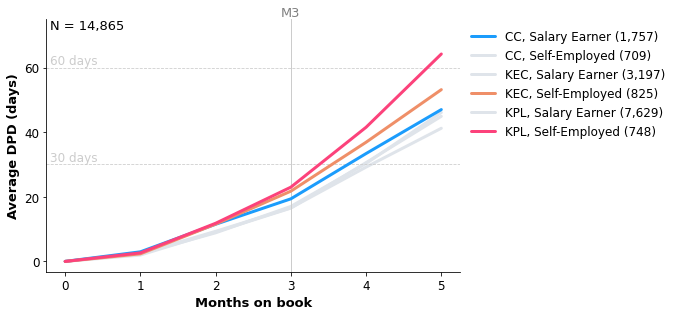

In [26]:
# "flag" "cust_type","apl_grp_type", "pd_lvl2"
groupby = ["pd_lvl2", "cust_type"] 
ax = plot_avgdpd(X.loc[X["clean"]==False], groupby, dpd_cols, 
                 start_mth=0, colors=colors, focus="M3", n_tops=3, 
                 ax=plt.subplots(figsize=(9.5,4.5))[1])

In [27]:
groupby_table(X.loc[X["clean"]==False], groupby, dpd_cols)

N        M0        M1         M2         M3  \
pd_lvl2 cust_type                                                       
CC      Salary Earner  1757  0.013090  2.974957  11.501992  19.370518   
        Self-Employed   709  0.000000  1.968970   9.112835  16.499295   
KEC     Salary Earner  3197  0.037222  2.486706   9.316547  16.573037   
        Self-Employed   825  0.001212  2.343030  11.544242  21.743030   
KPL     Salary Earner  7629  0.015729  2.365448   8.853061  17.023725   
        Self-Employed   748  0.000000  2.647059  11.807487  22.983957   

                              M4         M5  
pd_lvl2 cust_type                            
CC      Salary Earner  33.389300  46.993739  
        Self-Employed  30.589563  44.909732  
KEC     Salary Earner  29.190491  41.212074  
        Self-Employed  36.890909  53.164848  
KPL     Salary Earner  30.308691  46.083497  
        Self-Employed  41.526738  64.197861

In [28]:
groupby_table(X.loc[X["clean"]==False], groupby, osb_cols, 
              np.nansum, factor=1/10**6)

N       M0_OS       M1_OS       M2_OS       M3_OS  \
pd_lvl2 cust_type                                                             
CC      Salary Earner  1757    9.157084   20.194408   24.712070   29.679988   
        Self-Employed   709    8.800038   18.396231   23.301532   30.684498   
KEC     Salary Earner  3197   58.255892   68.506719   69.993572   72.690903   
        Self-Employed   825   48.817680   59.560702   61.562549   64.261457   
KPL     Salary Earner  7629  162.547851  162.496417  161.515799  160.784333   
        Self-Employed   748   88.578132   90.094874   89.858213   90.028720   

                            M4_OS       M5_OS  
pd_lvl2 cust_type                              
CC      Salary Earner   42.719003   46.446120  
        Self-Employed   41.269355   51.410811  
KEC     Salary Earner   73.793261   74.446608  
        Self-Employed   65.668621   66.551549  
KPL     Salary Earner  160.524370  160.782477  
        Self-Employed   90.669635   91.773494

## Vintage analysis

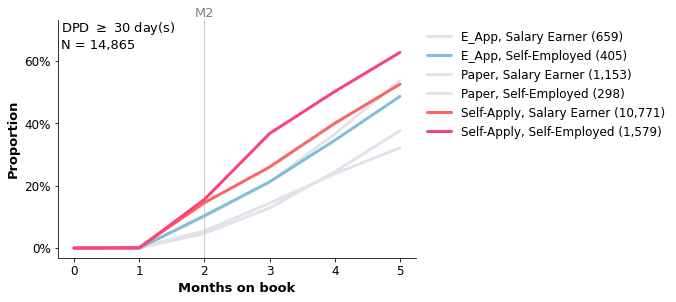

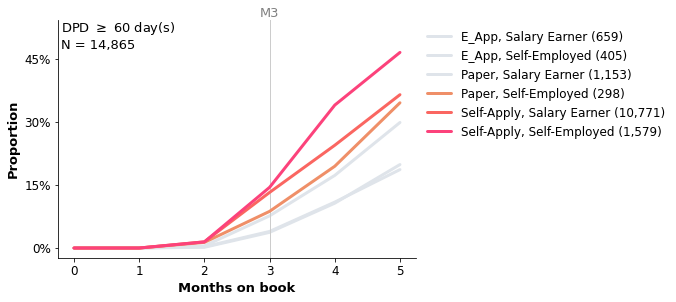

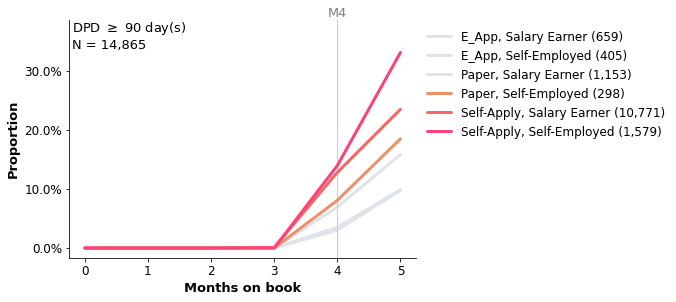

In [29]:
# "flag" "cust_type","apl_grp_type", "pd_lvl2"
groupby = ["apl_grp_type", "cust_type"] 
for dpd_geq,focus in zip([30, 60, 90],["M2","M3","M4"]):
    ax = plt.subplots(figsize=(9.5,4.3))[1]
    ax = plot_vintage(X.loc[(X["clean"]==False)], groupby, dpd_cols, 
                      dpd_geq, ax=ax, colors=colors, focus=focus, n_tops=3)

In [30]:
vintage_table(X.loc[X["clean"]==False], groupby, dpd_cols)

N   M0        M1        M2        M3  \
apl_grp_type cust_type                                                 
E_App        Salary Earner    659  0.0  0.003035  0.054628  0.144158   
             Self-Employed    405  0.0  0.000000  0.103704  0.212346   
Paper        Salary Earner   1153  0.0  0.000000  0.046834  0.128361   
             Self-Employed    298  0.0  0.000000  0.100671  0.211409   
Self-Apply   Salary Earner  10771  0.0  0.001671  0.145112  0.259864   
             Self-Employed   1579  0.0  0.000000  0.155795  0.367321   

                                  M4        M5  
apl_grp_type cust_type                          
E_App        Salary Earner  0.238240  0.321700  
             Self-Employed  0.345679  0.486420  
Paper        Salary Earner  0.244579  0.376409  
             Self-Employed  0.365772  0.536913  
Self-Apply   Salary Earner  0.400149  0.525578  
             Self-Employed  0.502217  0.627612

## Roll rate analysis

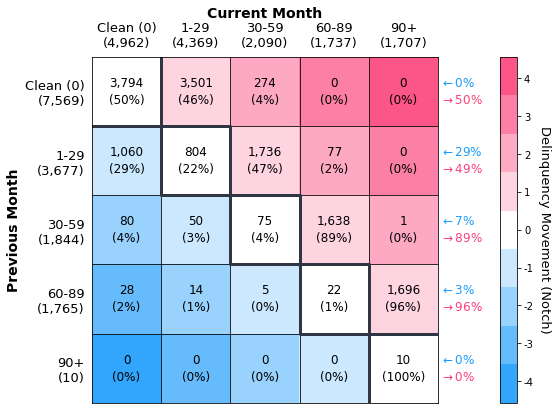

In [31]:
mobs, cond = ["M3","M4"], (X["clean"]==False) 
ax = plot_rollrate(X.loc[cond].copy(), mobs)

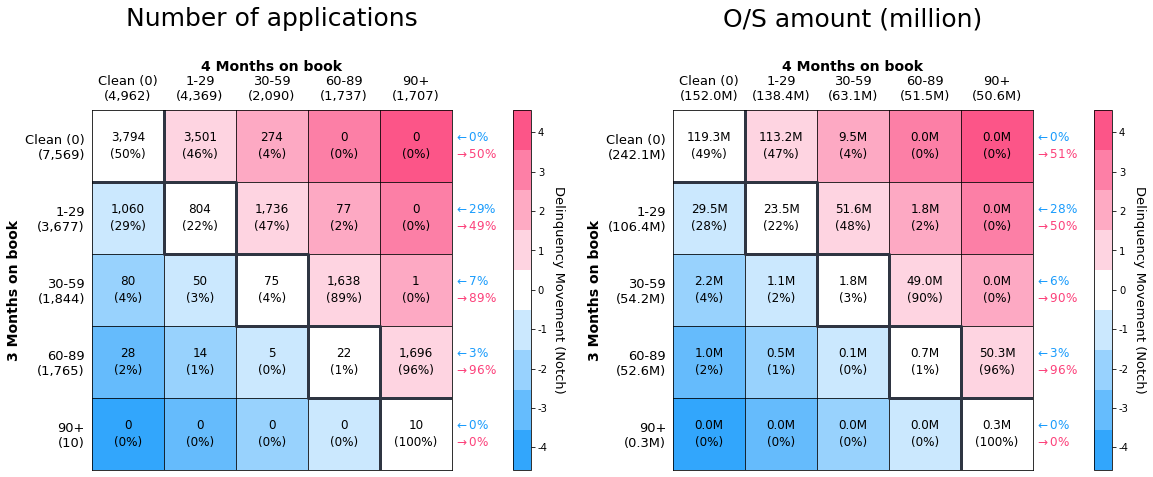

In [32]:
fig, axes = plt.subplots(1,2,figsize=(8.3*2,6.5))
fig.subplots_adjust(hspace=0.3)
mobs, cond = ["M3","M4"], (X["clean"]==False)
labels = np.r_[["{} Months on book".format(s[1:]) for s in mobs]][::-1]
axes[0] = plot_rollrate(X.loc[cond].copy(), mobs, ax=axes[0], labels=labels)
axes[1] = plot_rollrate(X.loc[cond].copy(), mobs, ax=axes[1], labels=labels,
                        values=X["M4_OS"]/10**6, num_format="{:,.1f}M".format)
axes[0].set_title("Number of applications\n", fontsize=25)
axes[1].set_title("O/S amount (million)\n", fontsize=25)
plt.tight_layout()

## % Withdrawal @ M0, and M1
add 90% flag

In [33]:
# "flag","pd_lvl2", "cust_type", "apl_grp_type"]
groupby= ["flag","pd_lvl2", "cust_type"]
aggfnc = {"ip_id" : "count", "M0_pWDL": "mean", "M1_pWDL": "mean"}
rename = {"ip_id":"N", "M0_pWDL": "M0", "M1_pWDL": "M1"}
X.loc[X["clean"]==False].groupby(groupby).agg(aggfnc).rename(columns=rename)

N        M0        M1
flag   pd_lvl2 cust_type                              
Fraud  KEC     Salary Earner   172  0.974616  0.993543
               Self-Employed    47  0.851064  0.999753
Normal CC      Salary Earner  1757  0.148159  0.299757
               Self-Employed   709  0.127012  0.248063
       KEC     Salary Earner  3025  0.765218  0.888476
               Self-Employed   778  0.725875  0.851166
       KPL     Salary Earner  7629  0.990954  0.971926
               Self-Employed   748  0.986478  0.985584

## Observed Default Rate (ODR) by scores

In [119]:
def ovserved_rate(X, scores, dpd_cols, dpd_geq=60, 
                  val_cols=None, bins=None):

scores = X["fico_scor"]
bins = None
val_cols = None #osb_cols
dpd_geq = 60

# Score bin edges
if bins is None: bins="fd"
scr_gt0 = scores[scores>0]
bins = np.round(np.histogram_bin_edges(scr_gt0, bins),0).astype(int)
bins[-1] = max(scores) + 1

x = (X[dpd_cols]>=dpd_geq).astype(int).copy()
if val_cols is not None: x *= X[val_cols].values
    
# right=False, bins[i-1] <= x < bins[i]
x["bin_lt"], x["N"] = np.digitize(scores, bins), 1
cat = dict([(n,c) for n,c in enumerate(bins)])
x["bin_lt"]  = x["bin_lt"].apply(lambda x: cat[x])

aggfunc = dict([("N","sum")]+[(c,"sum") for c in dpd_cols])
obs = x.groupby("bin_lt").agg(aggfunc)

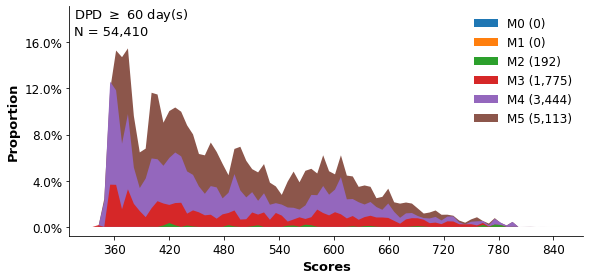

In [128]:


num_format = None
ax = None
colors = ["#1B9CFC","#CAD3C8","#F97F51","#FC427B"]
plot_kwds = None

 # Default parameters
args = (plot_kwds, num_format, ax, colors, len(dpd_cols), len(dpd_cols), None)
kwds, num_format, ax, colors = default_params(*args) 


n_samples = obs[dpd_cols].values.sum(0)

from scipy.interpolate import interp1d


for n,c in enumerate(dpd_cols): 
    
    x_ = np.array(obs.index)[1:]
    y_ = obs[c][1:]/obs["N"].values[1:]
    
    
    
    
    cubic_interploation_model = interp1d(x_, y_, kind = "cubic")

    # Plotting the Graph
    x_ = np.linspace(x_.min(), x_.max(), 80)
    y_ = np.fmax(cubic_interploation_model(x_),0)
    # edgecolor=colors[n]
    ax.fill_between(x_, y_, 
            label= c + " ({:,.0f})".format(n_samples[n]), zorder=-n)

    
ax = draw_text(ax, obs["N"][1:].sum(), dpd_geq)

x_ = np.array(obs.index)



# Set properties of x, and y axes.
ax = set_axes(ax, x_, 0, ylabel="Proportion", xlabel="Scores", percent=True)
ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(10))
ax = draw_legend(ax, "best")


plt.tight_layout()

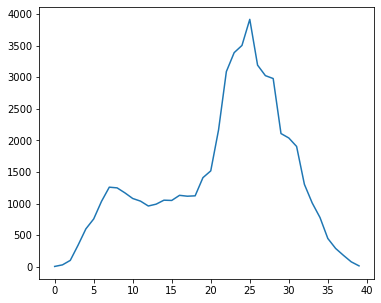

In [112]:
ax = plt.subplots(figsize=(6,5))[1]
ax.plot(obs["N"].values[1:])

In [ ]:
np.array(obs.index)

In [ ]:
scale, y_scale = 0.65, 0.8
y_min, y_max = ax.get_ylim()
y_max = np.fmax(max(lift) / y_scale, 0.5)
y_min = 1 - (y_max - 1)/scale * (1-scale)
ax.set_ylim(y_min, y_max)
ax.set_xlim(-0.8, len(x)-0.2)
ax.spines["left"].set_bounds((1, y_max))
# -------------------------------------------------------------
font_kwds.update(dict(color=colors[0]))
for n,s in zip(x,lift): 
    ax.annotate(anno_format(s), (n,s), **font_kwds)
# =============================================================

# =============================================================
y = np.interp(decile, Lift.cum_p_sample, Lift.n_target)
y = y / sum(Lift.n_target)
# -------------------------------------------------------------
twinx_ax = ax.twinx()
kwds = dict(color=colors[1], alpha=bar_kwds.get("alpha", 1), 
            edgecolor="none")
bar1 = twinx_ax.bar(x, y, **{**bar_kwds, **kwds})
kwds.update(dict(facecolor="none",edgecolor=colors[1],alpha=1))
twinx_ax.bar(x, y, **{**bar_kwds, **kwds})
# -------------------------------------------------------------
decimal = decimal if isinstance(decimal, int) else 0
font_kwds.update(dict(color=colors[1]))
for n,s in zip(x, y): 
    twinx_ax.annotate(("{:." + str(decimal) + "%}").format(s), 
                      (n,s), **font_kwds)
# -------------------------------------------------------------
tw_y_min, tw_y_max = twinx_ax.get_ylim()
tw_y_max = max(y) / y_scale
tw_y_max = tw_y_max + (tw_y_max / (1-scale))
twinx_ax.set_ylim(0, tw_y_max if tw_y_max > 0 else 1)
twinx_ax.spines["right"].set_visible(False)
twinx_ax.spines["top"].set_visible(False)
twinx_ax.axes.yaxis.set_visible(False)
twinx_ax.set_frame_on(False)
# =============================================================

# Set other attributes.
# =============================================================
args = (ax.transAxes, ax.transData)
transform = transforms.blended_transform_factory(*args)
ax.text(1.01, 1, "x", fontsize=13, va='center', ha="left", 
        transform=transform)
ax.axhline(1, ls="-", lw=1, zorder=1, color="k")
# -------------------------------------------------------------
ax.tick_params(axis='both', labelsize=10.5)
ax.set_xticks(x)
ax.set_xticklabels(['{:.0%}'.format(n) for n in decile])
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(6))
# -------------------------------------------------------------
ax.yaxis.set_minor_locator(FixedLocator([1]))
ax.tick_params(axis="y", which="minor", length=3.5, color="k")
yticks = ax.get_yticks()
ax.set_yticks(yticks[(yticks>=1) & (yticks<y_max)])
# -------------------------------------------------------------
ax.set_xlabel('Cumulative % of Samples', fontsize=13)
ax.set_facecolor('white')
ax.patch.set_alpha(0)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
# -------------------------------------------------------------
ax.set_ylabel('Cumulative Lift', fontsize=13)
y_min, y_max = ax.get_ylim()
offset = (1 - y_min)/(y_max - y_min)
incr = ((y_max - 1)/(y_max - y_min)) * 0.5
text = ax.yaxis.get_label()
left = text.get_position()[0]
text.set_position((left, offset + incr))
# -------------------------------------------------------------
args = (ax.transAxes, ax.transAxes)
transform = transforms.blended_transform_factory(*args)
ax.text(0, 1.01, "f(x)", fontsize=13, va='bottom', ha="center", 
        transform=transform)
ax.text(1.01, 0, "x", fontsize=13, va='center', ha="left", 
        transform=transform)
# -------------------------------------------------------------
patches = [bar0[0], bar1[0]]
labels  = ["Lift", "% Target"]
ax.legend(patches, labels, loc='upper right', edgecolor="none",
          prop=dict(weight="ultralight", size=12), ncol=2, 
          borderaxespad=0., bbox_to_anchor=(1, 1.07), 
          columnspacing=0.5, handletextpad=0.5)
if tight_layout: plt.tight_layout()

## Late loan (proportion) (app, value)

In [ ]:
dpd_cols = ["M0","M1","M2","M3","M4","M5"]
# bins[i-1] <= x < bins[i]
bins = [1, 30, 60, 90, 120, 150, 180]

cond = (X["pd_lvl2"]=="KEC") & (X["flag"]=="Normal")

new_X = pd.DataFrame(np.digitize(X.loc[cond,dpd_cols], bins, right=False), columns=dpd_cols)

In [ ]:
a = np.zeros((len(bins), len(dpd_cols)))
for n,var in enumerate(dpd_cols):
    index, cnt = np.unique(new_X[var], return_counts=True)
    a[index,[n]] = cnt

In [ ]:
ax = plt.subplots(figsize=(7,4.5))[1]
b = a/a.sum(0)
p = np.zeros(a.shape[1])
for n in np.arange(1,len(b)):
    c = b[n,:]
    ax.fill_between(xticks, p, p+c, alpha=0.8, ec="k",
                    label="{}-{}".format(*bins[n-1:n+1]), zorder=-1)
    p += c